In [1]:
# import model and everything needed to run it
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

import os
import numpy as np
from copy import deepcopy
from rbm_torch.models.pool_crbm_base import pool_CRBM
from rbm_torch.utils.utils import load_run_file

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

In [5]:
# load data from preconfigured run file
run_file = "./run_files/toy_pcrbm.json"
run_data, base_config = load_run_file(run_file)

base_config["model_name"] = run_data["model_name"]
base_config["gpus"] = run_data["gpus"]

model_type = run_data["model_type"]
assert model_type == "pool_crbm"

server_model_dir = run_data["server_model_dir"]
base_config['seed'] = 69

base_config['lgap'] = 0.0
base_config['lbs'] = 0.0
base_config['lcorr'] = 0.0
base_config['ld'] = 0.0
base_config['l1_2'] = 1.0
base_config['epochs'] = 1000

In [10]:
# Training Code for individual model
def train_model(config):
    model = pool_CRBM(config, debug=False, precision=config["precision"])
    logger = TensorBoardLogger(server_model_dir, name=config["model_name"])
    if config["gpus"] > 1:
        # distributed data parallel, multi-gpus on single machine or across multiple machines
        plt = Trainer(max_epochs=config['epochs'], logger=logger, gpus=run_data["gpus"], accelerator="cuda", strategy="ddp", enable_progress_bar=False, enable_model_summary=False)  # distributed data-parallel
    else:
        if config['gpus'] == 0:
            plt = Trainer(max_epochs=config['epochs'], logger=logger, accelerator="cpu", enable_progress_bar=False, enable_model_summary=False)
        else:
            plt = Trainer(max_epochs=config['epochs'], logger=logger, devices=run_data["gpus"], accelerator="cuda", enable_progress_bar=False, enable_model_summary=False)  # gpus=1,
    plt.fit(model)
    return

In [38]:
import tbparse
import pandas as pd
from rbm_torch.analysis import analysis_methods as am

def parse_tb_files_crbm(model_str, model_dir="./", version=None):
    """parses the log directory of a given model, and optionally version. Extracts data to a pandas dataframe for
    easy graphing of our model"""
    checkp, version_dir = am.get_checkpoint_path(model_str, rbmdir=model_dir, version=version)

    # Read in all scalar event files and extract info
    scalars = ["weight_reg", "field_reg", "distance_reg", "gap_reg", "free_energy_diff", "loss", "free_energy_pos", "free_energy_neg", "Input Correlation Reg"]
    dfs = []
    for scalar in scalars:
        reader = tbparse.SummaryReader(f"{version_dir}/Train Scalars_{scalar}")
        df = reader.scalars
        rename = {"Train Scalars": scalar}
        df.replace({"tag": rename}, inplace=True)
        dfs.append(df)

    # Read in the main event file and drop almost all the information in it
    reader = tbparse.SummaryReader(version_dir)
    df = reader.scalars
    print(df.keys())

    removal_tags = ["Train Scalars", "Val Scalars", "hp_metric", "train_free_energy_epoch", "val_free_energy_epoch", "ptl/free_energy_diff_step",
                    "val_free_energy_step", "train_free_energy_step", "train_loss_step", "epoch", "train_loss_epoch"]
    rename_tags = {"ptl/train_free_energy_epoch": "train_free_energy_epoch",
                   "ptl/val_free_energy": "val_free_energy"}

    # Everything is Removed except for the Validation Free Energy
    for rtag in removal_tags:
        df.drop(df[df['tag'].str.contains(rtag)].index, inplace = True)

    df.replace({"tag": rename_tags}, inplace=True)

    df = df.iloc[1: , :] # Removes a false 0 step value for the Validation Free Energy
    dfs.append(df)

    df = pd.concat(dfs)  # Join all dfs together
    df.rename(columns={"step": "Epoch", "tag": "Scalar", "value": "Value"}, inplace=True)  # rename columns to epoch
    df.reset_index(inplace=True, drop=True)
    df["Model"] = model_str
    return df

In [6]:
# define several models for comparison across a single variable
vary = "ld"
vrange = np.geomspace(0.001, 1.0, num=10).tolist()
vrange.insert(0, 0.)
vrange = [round(x, 3) for x in vrange]


model_configs = [deepcopy(base_config) for _ in vrange]

for vid, vval in enumerate(vrange):
    model_configs[vid][vary] = vval
    model_configs[vid]["model_name"] += f"_{vary}_{vid}"

In [ ]:
cdir = os.getcwd()
os.chdir("/home/jonah/PycharmProjects/phage_display_ML/")

for vid in range(len(vrange)):
    train_model(model_configs[vid])

os.chdir(cdir)

Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')


AttributeError: Line2D.set() got an unexpected keyword argument 'range'

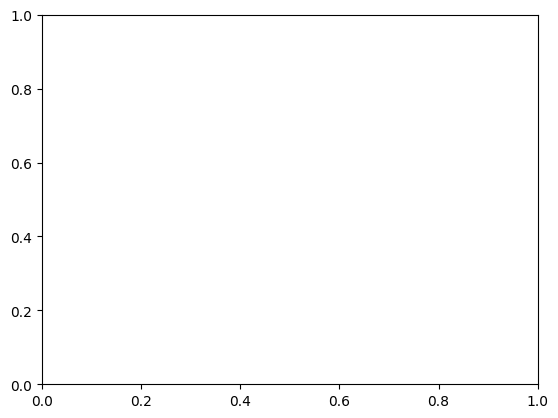

In [41]:
# define several models for comparison across a single variable
vary = "ld"
vrange = np.geomspace(0.001, 0.1, num=6).tolist()
vrange.insert(0, 0.)
vrange = [round(x, 3) for x in vrange]

model_configs = [deepcopy(base_config) for _ in vrange]
for vid, vval in enumerate(vrange):
    model_configs[vid][vary] = vval
    model_configs[vid]["model_name"] += f"_{vary}_{vid}"


dfs = []
for i in range(len(vrange)):
    df = parse_tb_files_crbm(model_configs[i]["model_name"], model_dir="./trained_crbms/")
    dfs.append(df)
df = pd.concat(dfs)  # Join all dfs together

(0.0, 0.2)

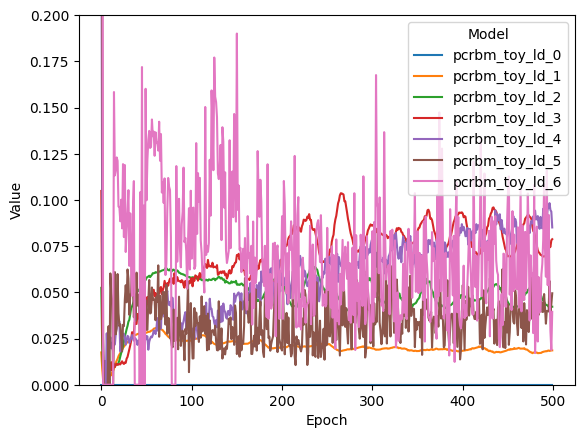

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

key = 'distance_reg'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", hue="Model")
plt.ylim(0.0, 0.2)

<Axes: xlabel='Epoch', ylabel='Value'>

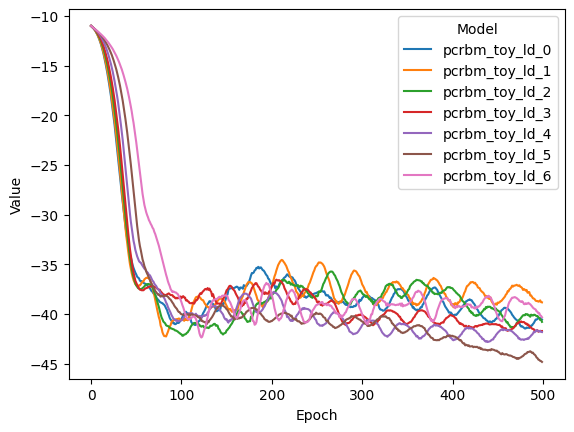

In [44]:
key = 'free_energy_pos'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", hue="Model")
# plt.ylim(0.0, 0.2)

In [11]:
# single variable
vary = "l1_2"
vrange = np.geomspace(0.1, 50.0, num=6).tolist()
vrange.insert(0, 0.)
vrange = [round(x, 3) for x in vrange]


model_configs = [deepcopy(base_config) for _ in vrange]

for vid, vval in enumerate(vrange):
    model_configs[vid][vary] = vval
    model_configs[vid]["model_name"] += f"_{vary}_{vid}"

dir = os.getcwd()
os.chdir("/home/jonah/PycharmProjects/phage_display_ML/")

for vid in range(len(vrange)):
    train_model(model_configs[vid])

os.chdir(cdir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0024302005767822266


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002836465835571289


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002729654312133789


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0028488636016845703


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003131866455078125


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_5
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002741098403930664


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_l1_2_6
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003034830093383789


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.


In [12]:
# define several models for comparison across a single variable
vary = "lbs"
vrange = np.geomspace(0.001, 1.0, num=6).tolist()
vrange.insert(0, 0.)
vrange = [round(x, 3) for x in vrange]


model_configs = [deepcopy(base_config) for _ in vrange]

for vid, vval in enumerate(vrange):
    model_configs[vid][vary] = vval
    model_configs[vid]["model_name"] += f"_{vary}_{vid}"

dir = os.getcwd()
os.chdir("/home/jonah/PycharmProjects/phage_display_ML/")

for vid in range(len(vrange)):
    train_model(model_configs[vid])

os.chdir(cdir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002869844436645508


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0031070709228515625


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0028018951416015625


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0028238296508789062


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002929210662841797


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_5
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002717256546020508


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: datasets/toy/trained_crbms/pcrbm_toy_lbs_6
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.002569913864135742


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=500` reached.


In [33]:
df = parse_tb_files_crbm("pcrbm_toy_l1_2_0", model_dir="./trained_crbms/")

Index(['step', 'tag', 'value'], dtype='object')


In [34]:
set(df["Scalar"].to_list())

{'Input Correlation Reg',
 'distance_reg',
 'field_reg',
 'free_energy_diff',
 'free_energy_neg',
 'free_energy_pos',
 'gap_reg',
 'loss',
 'val_free_energy',
 'weight_reg'}

<Axes: xlabel='Epoch', ylabel='Value'>

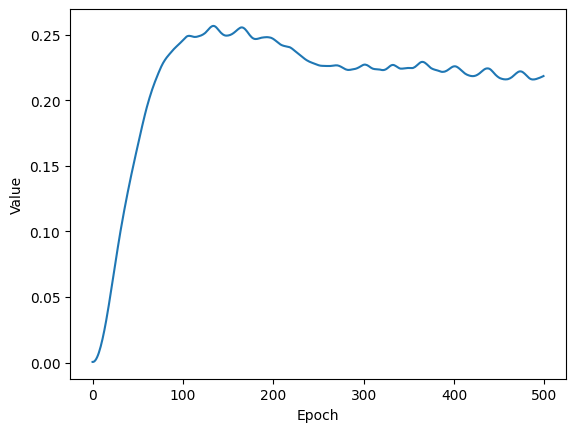

In [37]:
import seaborn as sns

key = 'field_reg'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", )